In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#replace with your path to the folder with Project contents
%cd /content/drive/MyDrive/AML/AML_course/Project

/content/drive/MyDrive/AML/AML_course/Project


In [3]:
!pip install torcheval
!pip install lpips

import torch
import torch.nn as nn
import torch.optim as optim
import os
import shutil
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scipy.io
import json
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import random
from tqdm import tqdm
import numpy as np
from PIL import Image

from modules.data_preprocessing import data_reallocation, create_datasets
from modules.train_classfier import train, test_eval, set_seed
from modules.generate_images import generate_from_prompt
from modules.FID import FID
from modules.textual_inversion import TextualInversionDataset, initialize_model, training_function, save_concept

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.4 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
set_seed(42)

In [5]:
def set_seed_nb(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If you use multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures reproducibility for convolutional layers
    torch.backends.cudnn.benchmark = False  # Disable optimization for reproducibility

set_seed_nb()

In [6]:
%cd /content

/content


### Data preprocessing

In [7]:
import gdown
url = "https://drive.google.com/drive/folders/1c2xufL1sNJHbQ3v3b5l1jmYx86ahDgLQ"

gdown.download_folder(url, output='flower102')

Retrieving folder contents


Processing file 1NVV3x5bnHk0kDnxQuCtjJFrVdVSh96ID 102flowers.tgz
Processing file 1kW4gIHlC82lDDdPRNf-ib1go1ekM05mL cat_to_name.json
Processing file 1thBhdGC6oJywetBBiFcmh5OI7mX9DpGn imagelabels.mat
Processing file 1m8mSQlD27WR2vHp-PkiQ_17ts408xn10 setid.mat


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1NVV3x5bnHk0kDnxQuCtjJFrVdVSh96ID
From (redirected): https://drive.google.com/uc?id=1NVV3x5bnHk0kDnxQuCtjJFrVdVSh96ID&confirm=t&uuid=5ebedce1-1a7c-4edb-b19a-40aea122d28b
To: /content/flower102/102flowers.tgz
100%|██████████| 345M/345M [00:02<00:00, 131MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kW4gIHlC82lDDdPRNf-ib1go1ekM05mL
To: /content/flower102/cat_to_name.json
100%|██████████| 2.22k/2.22k [00:00<00:00, 7.59MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1thBhdGC6oJywetBBiFcmh5OI7mX9DpGn
From (redirected): https://drive.google.com/uc?id=1thBhdGC6oJywetBBiFcmh5OI7mX9DpGn&confirm=t&uuid=a41d779b-febc-431b-aa1f-125510539e78
To: /content/flower102/imagelabels.mat
100%|██████████| 502/502 [00:00<00:00, 1.69MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1m8mSQlD27W

['flower102/102flowers.tgz',
 'flower102/cat_to_name.json',
 'flower102/imagelabels.mat',
 'flower102/setid.mat']

In [8]:
import tarfile
source_path = "flower102/102flowers.tgz"
destination_path = "flower102"

with tarfile.open(source_path, "r:gz") as tar:
      tar.extractall(path=destination_path)

os.remove(source_path)

In [9]:
# Define paths
data_path = 'flower102'
images_path = os.path.join(data_path, 'jpg')
output_path = 'data'

data_reallocation(data_path,
                  images_path,
                  output_path)

Images reallocated successfully to folder data


In [10]:
train_dataset, val_dataset, test_dataset = create_datasets(output_path, batch_size=32)
generator = torch.Generator().manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator = generator)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

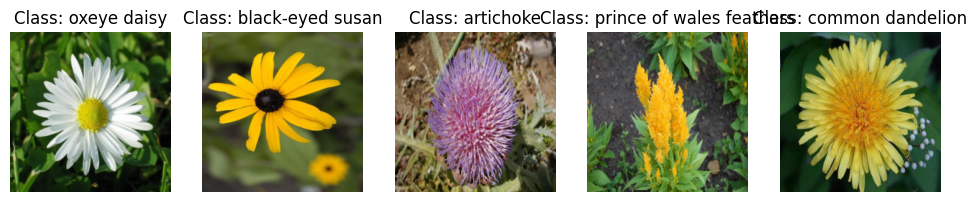

In [11]:
# plot 4 images from data
swapped_dict = {value: key for key, value in train_dataset.class_to_idx.items()}
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for ax in axes:
    picture_number = random.randint(0, len(train_dataset))
    image = train_dataset[picture_number][0].permute(1, 2, 0)
    #unnormalize
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    ax.imshow(image)
    ax.set_title(f"Class: {swapped_dict[train_dataset[picture_number][1]]}")
    ax.axis('off')


### Classification model training and evaluation

In [ ]:
model = torchvision.models.resnet50(pretrained=True)
num_epochs = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam
criterion = nn.CrossEntropyLoss()
path_to_save_model = 'model.pth'
lr = 0.001
num_classes = len(train_loader.dataset.classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


Val: Epoch [1/8], n\Loss: 3.5267, n\Accuracy: 24.0196


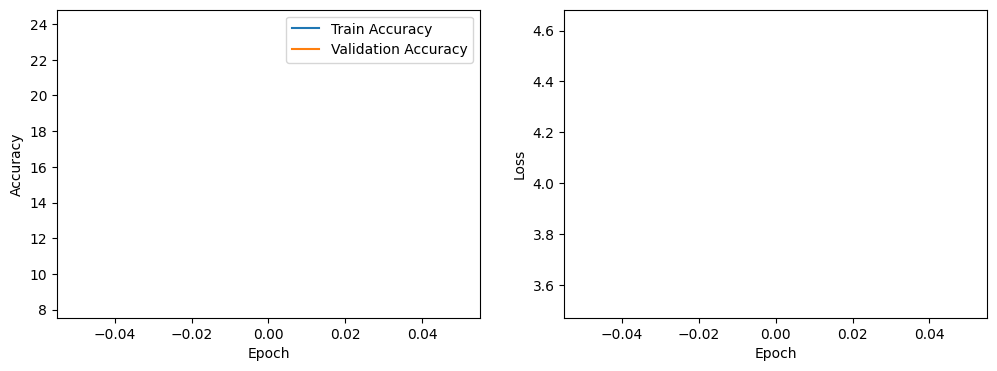

Val: Epoch [2/8], n\Loss: 2.3154, n\Accuracy: 62.5490


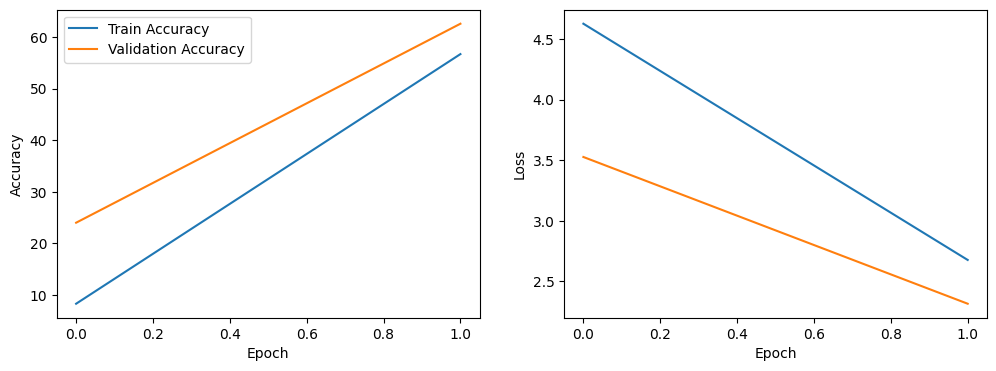

Val: Epoch [3/8], n\Loss: 1.7056, n\Accuracy: 73.6275


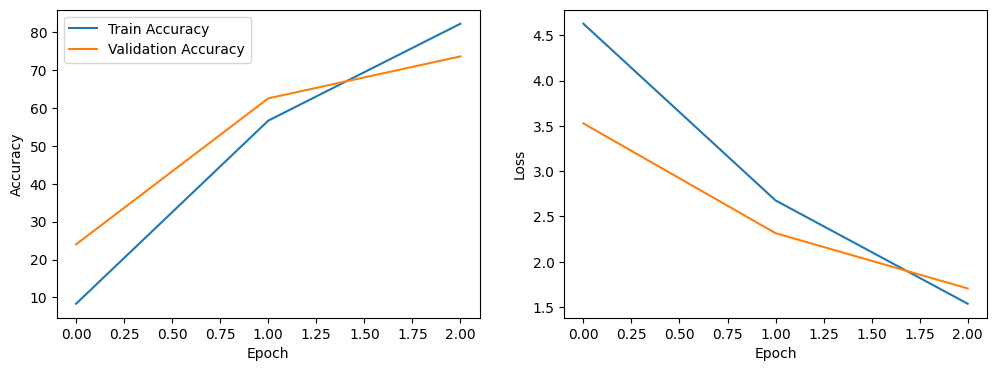

Val: Epoch [4/8], n\Loss: 1.3726, n\Accuracy: 76.5686


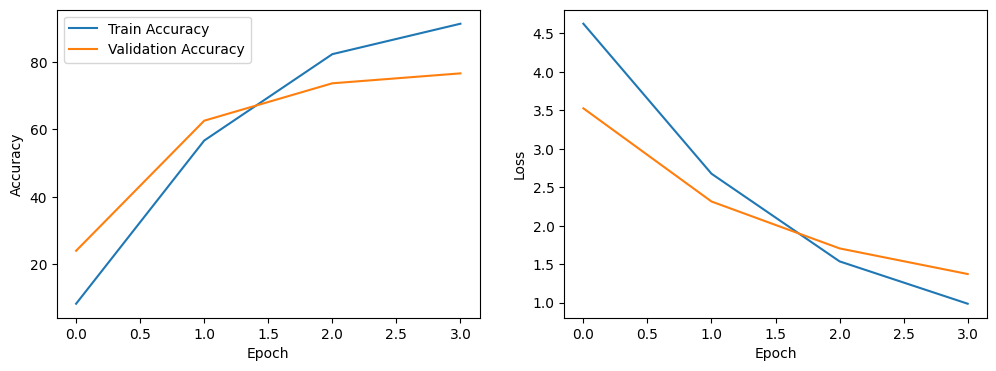

Val: Epoch [5/8], n\Loss: 1.1644, n\Accuracy: 79.3137


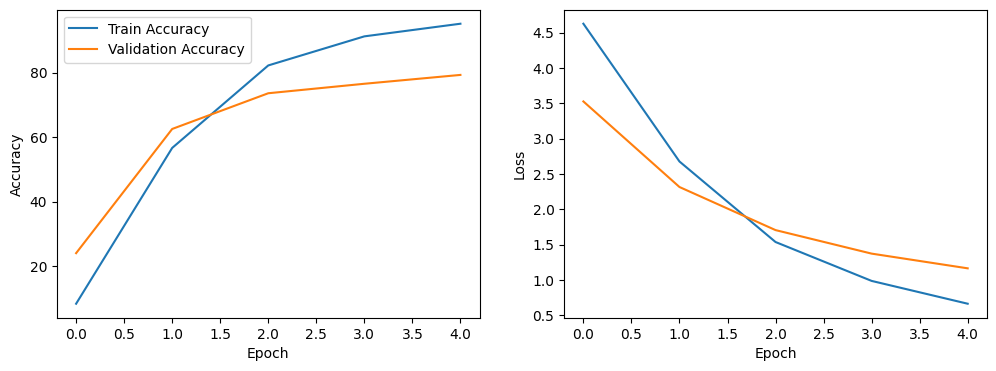

Val: Epoch [6/8], n\Loss: 1.0087, n\Accuracy: 82.2549


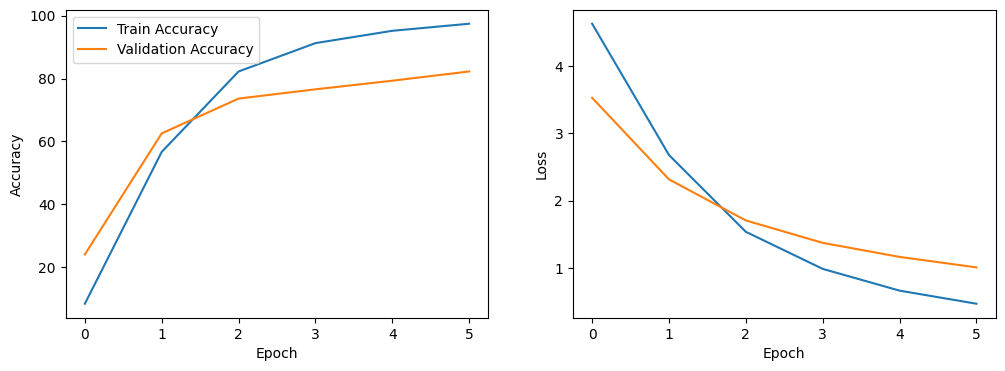

Val: Epoch [7/8], n\Loss: 0.9487, n\Accuracy: 83.3333


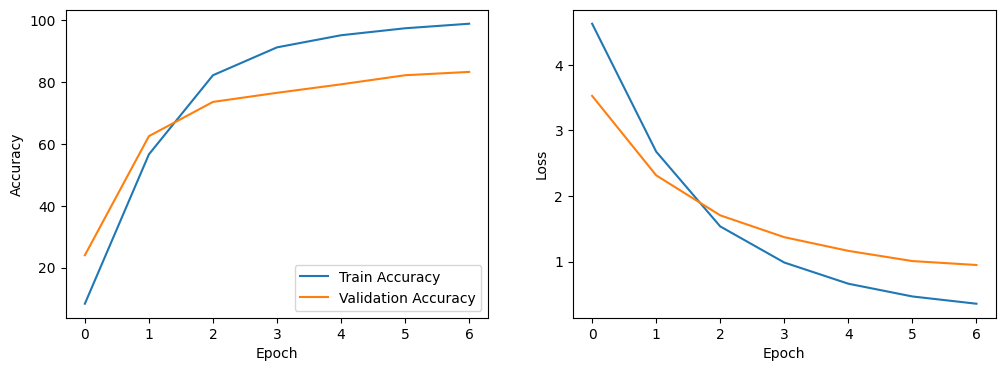

Val: Epoch [8/8], n\Loss: 0.8528, n\Accuracy: 83.6275


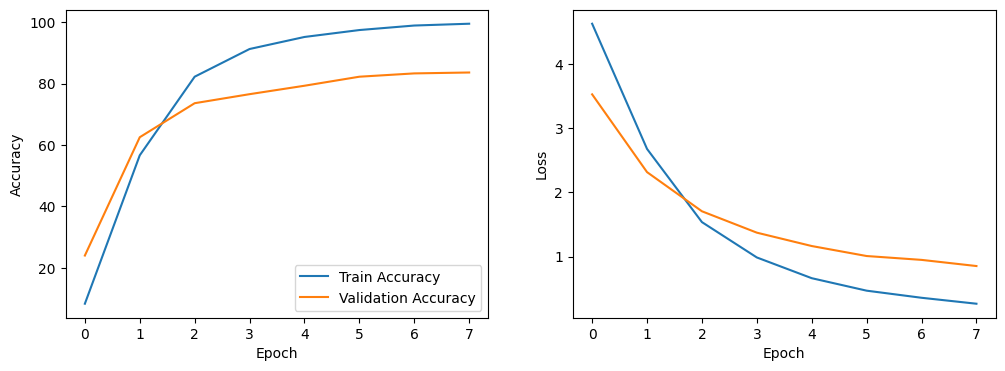

In [ ]:
train(train_loader,
      val_loader,
      model = model,
      num_epochs = num_epochs,
      device = device,
      criterion = criterion,
      optimizer = optimizer,
      lr = lr,
      path_to_save_model = path_to_save_model,
      num_classes = num_classes)

In [ ]:
test_eval(test_loader,
    model = model,
    device = device,
    path_to_save_model = path_to_save_model)

/content/drive/MyDrive/AML/AML_course/Project/modules/train_classfier.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_to_save_mod

Test Accuracy: 81.5905


### Worst performing classes

#### Load saved model

In [ ]:
#saved model
from torchvision import models
file_id = '13_JZTx1RfnKvhioYZ65gR-nCwcgFVfmS'
output = 'model.pth'
gdown.download(id=file_id, output=output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=13_JZTx1RfnKvhioYZ65gR-nCwcgFVfmS
From (redirected): https://drive.google.com/uc?id=13_JZTx1RfnKvhioYZ65gR-nCwcgFVfmS&confirm=t&uuid=5059b3a9-823d-489f-b146-46a9b98314b8
To: /content/model.pth
100%|██████████| 95.2M/95.2M [00:03<00:00, 26.7MB/s]


'model.pth'

In [ ]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 102) # 102 is the number of classes in flower102
model.load_state_dict(torch.load(output))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-13-ee3120f96e31>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Calculate metrics

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

 56%|█████▋    | 18/32 [00:06<00:04,  2.98it/s]


KeyboardInterrupt: 

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
class_f1 = []
class_precision = []
class_recall = []
num_classes = cm.shape[0]
num_confused_classes = []

for i in range(num_classes):
  precision = cm[i, i] / np.sum(cm[:, i]) if np.sum(cm[:,i]) > 0 else 0
  recall = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i,:]) > 0 else 0
  f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
  print(f"Class: {swapped_dict[i]}, F1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")
  class_f1.append(f1)
  class_precision.append(precision)
  class_recall.append(recall)
  confused_classes = np.where(cm[i, :] > 0)[0]  # All classes where there are non-zero predictions
  confused_classes = confused_classes[confused_classes != i]  # Exclude the correct class
  num_confused_classes.append(len(confused_classes))
  print(f"Confused with classes: {confused_classes}")

In [ ]:
worst_classes_indices = np.argsort(num_confused_classes)[:-20:-1]

print("20 Classes with most confusions:")
for i in worst_classes_indices:
    print(f"Class: {swapped_dict[i]}, {i} -  num_confused_classes: {num_confused_classes[i]}, F1: {class_f1[i]:.4f}, precision: {class_precision[i]:.4f}, recall: {class_recall[i]:.4f}")

In [ ]:
worst_classes_indices = np.argsort(class_recall)[:20]

print("20 Classes with worst validation recall:")
for i in worst_classes_indices:
    print(f"Class: {swapped_dict[i]}, {i} F1: {class_f1[i]:.4f}, precision: {class_precision[i]:.4f}, recall: {class_recall[i]:.4f}")

In [ ]:
worst_classes_indices = np.argsort(class_f1)[:20]

print("20 Classes with worst validation F1:")
for i in worst_classes_indices:
    print(f"Class: {swapped_dict[i]}, {i} F1: {class_f1[i]:.4f}, precision: {class_precision[i]:.4f}, recall: {class_recall[i]:.4f}")

In [ ]:
worst_class = worst_classes_indices[0]
worst_class

In [ ]:
indices = np.where(all_labels == worst_class)[0]
preds_worst_class = np.array(all_preds)[indices]
[swapped_dict[i] for i in preds_worst_class]

In [ ]:
worst_class_indices = [i for i, (img, label) in enumerate(val_dataset) if label == worst_class]

num_images_to_display = 7
selected_indices = np.random.choice(worst_class_indices, size=min(num_images_to_display, len(worst_class_indices)), replace=False)

fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))
for i, idx in enumerate(selected_indices):
    image, label = val_dataset[idx]
    image = image.permute(1, 2, 0)* torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    predicted_label = all_preds[idx]
    axes[i].imshow(image)
    axes[i].set_title(f"True: {swapped_dict[label]}\nPred: {swapped_dict[predicted_label]}")
    axes[i].axis('off')

plt.show()

### Sampling from raw StableDiffusion with prompts

In [ ]:
# swapped_dict = {1: "sword lily"}
# worst_class = 1
# swapped_dict[worst_class]

'sword lily'

In [ ]:
model_id = "stabilityai/stable-diffusion-2"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
output_dir = 'raw_model_examples_' + swapped_dict[worst_class]
os.makedirs(output_dir, exist_ok=True)

generate_from_prompt(model_id = model_id,
                     prompt = f"A photo of a {swapped_dict[worst_class]}",
                     device = device,
                     output_dir = output_dir,
                     num_images = 10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples_sword lily/a_photo_of_a_gladiolus_0.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples_sword lily/a_photo_of_a_gladiolus_1.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples_sword lily/a_photo_of_a_gladiolus_2.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples_sword lily/a_photo_of_a_gladiolus_3.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples_sword lily/a_photo_of_a_gladiolus_4.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples_sword lily/a_photo_of_a_gladiolus_5.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples_sword lily/a_photo_of_a_gladiolus_6.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples_sword lily/a_photo_of_a_gladiolus_7.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples_sword lily/a_photo_of_a_gladiolus_8.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples_sword lily/a_photo_of_a_gladiolus_9.png


In [ ]:
!pip install torcheval
from torcheval import metrics
fid_metric = metrics.FrechetInceptionDistance(device = device)

In [ ]:
from PIL import Image
from torchvision.transforms import ToTensor, Resize, Normalize

transform = Resize((299, 299))
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    tensor = ToTensor()(image)
    tensor = transform(tensor)
    tensor = normalize(tensor)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

In [ ]:
path_to_real_images = os.path.join('data/val', swapped_dict[worst_class])
path_to_real_images_train = os.path.join('data/train', swapped_dict[worst_class])

fake_images = torch.stack([preprocess_image(os.path.join(output_dir, filename)) for filename in os.listdir(output_dir)])
real_images = torch.stack([preprocess_image(os.path.join(path_to_real_images, filename)) for filename in os.listdir(path_to_real_images)])
real_images_train = torch.stack([preprocess_image(os.path.join(path_to_real_images_train, filename)) for filename in os.listdir(path_to_real_images_train)])

fid_metric.update(real_images, is_real=True)
# fid_metric.update(real_images_train, is_real=True)
fid_metric.update(fake_images, is_real=False)

In [ ]:
fid_metric.compute()

tensor(258.7234, device='cuda:0')

In [ ]:
# output_dir = 'drive/MyDrive/AML/raw_model_examples'

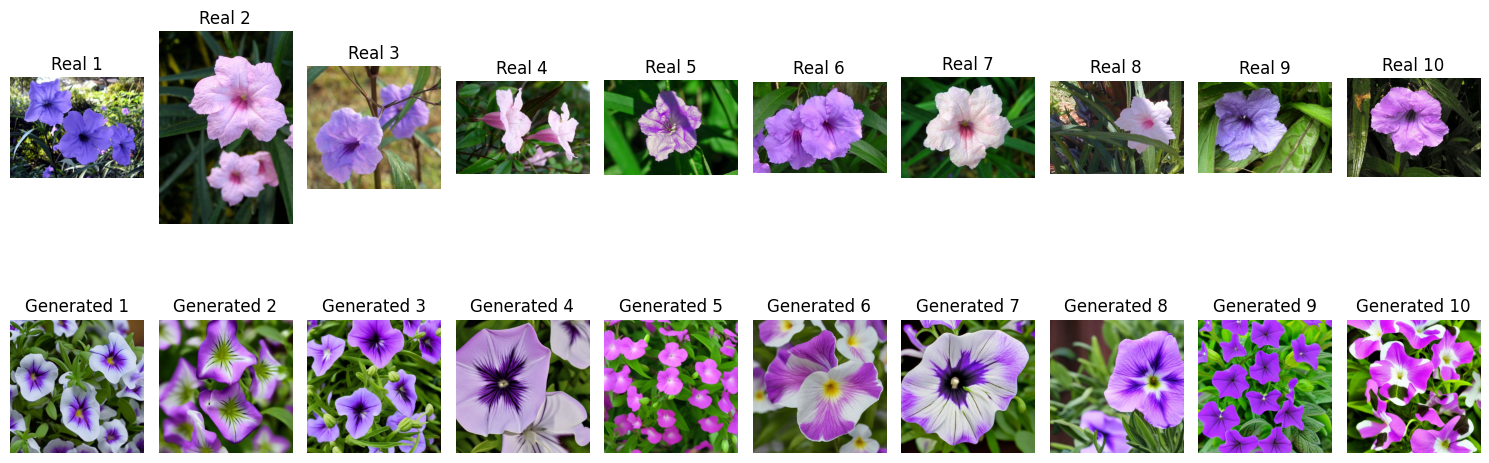

In [ ]:

num_images_to_display = min(len(os.listdir(output_dir)), len(os.listdir(path_to_real_images)))
fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 6))

# Display real images
for i, filename in enumerate(os.listdir(path_to_real_images)[:num_images_to_display]):
    image_path = os.path.join(path_to_real_images, filename)
    img = Image.open(image_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Real {i+1}")
    axes[0, i].axis('off')

# Display generated images
for i, filename in enumerate(os.listdir(output_dir)[:num_images_to_display]):
    image_path = os.path.join(output_dir, filename)
    img = Image.open(image_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Generated {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Textual inversion

In [12]:
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate transformers ftfy
from diffusers import DDPMScheduler
import itertools
import torch
import accelerate
from huggingface_hub import notebook_login

notebook_login()

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.3 MB/s eta 0:00:00


In [13]:
# random class choice if no worst class defined class exist
worst_class = worst_class if 'worst_class' in locals() else random.randint(0, 101)
print(f"worst class: {swapped_dict[worst_class]}")

#prepare data for textual inversion
data_path = f"data/train/{swapped_dict[worst_class]}"
save_path = "textual_inversion_images"
os.makedirs(save_path, exist_ok=True)

for filename in os.listdir(data_path):
    source_path = os.path.join(data_path, filename)
    destination_path = os.path.join(save_path, filename)
    if os.path.isfile(source_path):
        shutil.copy2(source_path, destination_path)

worst class: daffodil


In [14]:
# set up parameters for textual inversion

what_to_teach = "object"
placeholder_token = f"<{swapped_dict[worst_class]}>"
# initializer_token = swapped_dict[worst_class]
# placeholder_token = "<another-flower>"
initializer_token = "flower"
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2"

name_of_your_concept = swapped_dict[worst_class]

In [15]:
text_encoder, vae, unet, tokenizer, placeholder_token_id = initialize_model(
    pretrained_model_name_or_path, placeholder_token, initializer_token
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [16]:
train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=vae.sample_size,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)

<ipython-input-16-fb25fea1ebcb>:4: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  size=vae.sample_size,


In [17]:
noise_scheduler = DDPMScheduler.from_config(pretrained_model_name_or_path, subfolder="scheduler")


hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 2000,
    "save_steps": 250,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": "sd-concept-output"
}
!mkdir -p sd-concept-output

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

In [18]:
accelerate.notebook_launcher(training_function, args=(text_encoder,
                                                      vae,
                                                      unet,
                                                      hyperparameters,
                                                      train_dataset,
                                                      noise_scheduler,
                                                      tokenizer,
                                                      placeholder_token_id,
                                                      placeholder_token,
                                                      pretrained_model_name_or_path))

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

Launching training on one GPU.


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [19]:
save_concept(
    hyperparameters=hyperparameters,
    path_with_images=save_path,
    name_of_your_concept= name_of_your_concept,
    placeholder_token = placeholder_token,
    what_to_teach = what_to_teach,
    pretrained_model_name_or_path = pretrained_model_name_or_path)

learned_embeds.bin:   0%|          | 0.00/5.31k [00:00<?, ?B/s]

### Sampling from StableDiffusion with prompt using new token

In [ ]:
repo_id_embeds = "sd-concepts-library/sword-lily-flowers102"
model_id = "stabilityai/stable-diffusion-2"

In [ ]:
from diffusers import StableDiffusionPipeline
pipe = pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
).to("cuda")

pipe.load_textual_inversion(repo_id_embeds)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

OSError: sd-concepts-library/sword-lily-flowers102 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `token` or log in with `huggingface-cli login`.

In [ ]:
prompt = f"A photo of a {placeholder_token}"


num_samples = 10
num_rows = 1

all_images = []

output_dir = 'trained_model_examples'
os.makedirs(output_dir, exist_ok=True)
for _ in range(num_rows):
    images = pipe([prompt] * num_samples,  guidance_scale=7.5).images
    all_images.extend(images)

    # Save images to the specified directory
    for i, image in enumerate(images):
        name = f"{prompt.lower().replace(' ', '_')}_{_+i}.png"
        image_path = os.path.join(output_dir, name)
        image.save(image_path)

grid = image_grid(all_images, num_rows, num_samples)
grid

### Generations Analysis

In [ ]:
# path_to_real_images = os.path.join('data/val', swapped_dict[worst_class])
# path_to_generated_images_raw = 'raw_model_examples_' + swapped_dict[worst_class]
# path_to_generated_images_ti = output_dir
path_to_generated_images_raw = "drive/MyDrive/AML/raw_model_examples_sword lily"
path_to_generated_images_ti = "drive/MyDrive/AML/trained_model_examples"
path_to_real_images = "data/val/sword lily"

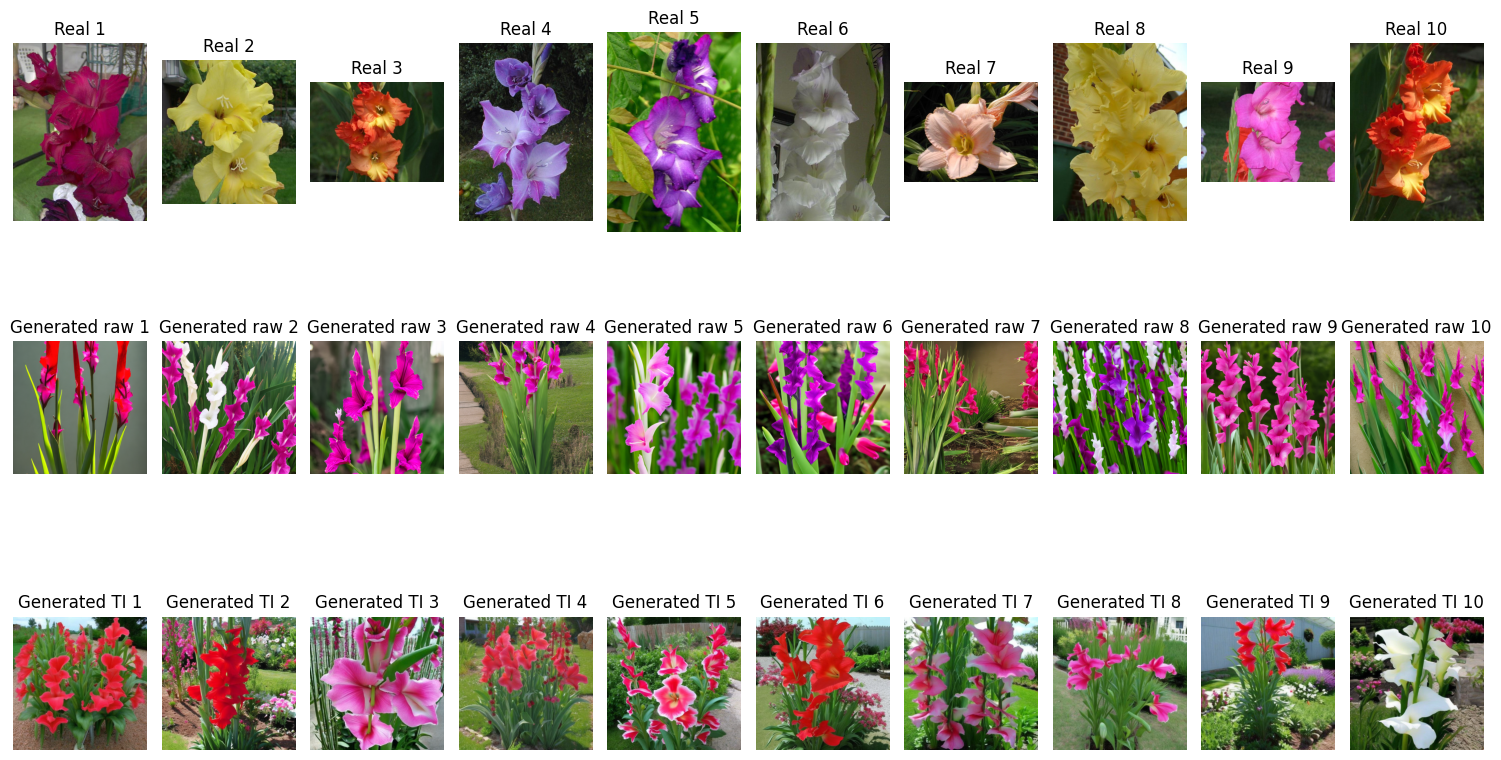

In [ ]:
num_images_to_display = min(len(os.listdir(path_to_real_images)),
                            len(os.listdir(path_to_generated_images_raw)),
                            len(os.listdir(path_to_generated_images_ti)))
fig, axes = plt.subplots(3, num_images_to_display, figsize=(15, 9))

# Display real images
for i, filename in enumerate(os.listdir(path_to_real_images)[:num_images_to_display]):
    image_path = os.path.join(path_to_real_images, filename)
    img = Image.open(image_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Real {i+1}")
    axes[0, i].axis('off')

# Display generated images
for i, filename in enumerate(os.listdir(path_to_generated_images_raw)[:num_images_to_display]):
    image_path = os.path.join(path_to_generated_images_raw, filename)
    img = Image.open(image_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Generated raw {i+1}")
    axes[1, i].axis('off')

# Display generated images after Textual inversion
for i, filename in enumerate(os.listdir(path_to_generated_images_ti)[:num_images_to_display]):
    image_path = os.path.join(path_to_generated_images_ti, filename)
    img = Image.open(image_path)
    axes[2, i].imshow(img)
    axes[2, i].set_title(f"Generated TI {i+1}")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
path_to_generated_images_raw = "drive/MyDrive/AML/raw_model_examples_sword lily"
path_to_generated_images_ti = "drive/MyDrive/AML/trained_model_examples"
path_to_real_images = "data/val/sword lily"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FID(path_to_real_images, path_to_generated_images_raw, device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:02<00:00, 47.8MB/s]


tensor(308.4080, device='cuda:0')

In [ ]:
path_to_real_images = "data/train/sword lily"
print(f"FID train - raw: {FID(path_to_real_images, path_to_generated_images_raw, device)}")
print(f"FID train - ti: {FID(path_to_real_images, path_to_generated_images_ti, device)}")

FID train - raw: 256.52276611328125
FID train - ti: 239.9832763671875


In [ ]:
path_to_real_images = "data/val/sword lily"
print(f"FID val - raw: {FID(path_to_real_images, path_to_generated_images_raw, device)}")
print(f"FID val - ti: {FID(path_to_real_images, path_to_generated_images_ti, device)}")

FID val - raw: 308.40802001953125
FID val - ti: 276.47149658203125


In [ ]:
path_to_real_images = "data/test/sword lily"
print(f"FID test - raw: {FID(path_to_real_images, path_to_generated_images_raw, device)}")
print(f"FID test - ti: {FID(path_to_real_images, path_to_generated_images_ti, device)}")

FID test - raw: 266.471923828125
FID test - ti: 240.8314208984375


In [ ]:
path_to_real_images = "data/train/sword lily"
path_to_fake_images = "data/val/sword lily"
print(f"FID train - val: {FID(path_to_real_images, path_to_fake_images, device)}")

FID train - val: 226.42584228515625


In [ ]:
path_to_real_images = "data/test/azalea"
path_to_fake_images = "data/test/sword lily"
print(f"FID: {FID(path_to_real_images, path_to_fake_images, device)}")

FID: 132.0184326171875


In [ ]:
# import lpips
# loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
# loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

# import torch
# img0 = torch.zeros(1,3,64,64) # image should be RGB, IMPORTANT: normalized to [-1,1]
# img1 = torch.zeros(1,3,64,64)
# d = loss_fn_alex(img0, img1)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 71.9MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


### Retrain Classifier

In [ ]:
path_to_generated_images_ti = 'trained_model_examples'

url = "https://drive.google.com/drive/folders/11OHWZTSm9BQsPw5qc3iv1iT17QeIonm9"

gdown.download_folder(url, output=path_to_generated_images_ti)

Retrieving folder contents


Processing file 1WLRdQiT9mPOZFCOC4t_qhSHEQomtDX5T a_photo_of_a__sword_lily__0.png
Processing file 1WoLzSQrgVHAW-vBAjdbDhAxW6MY9gsm6 a_photo_of_a__sword_lily__1.png
Processing file 1VeuoKck-kkJoGnLCRL3Mt-Zgs3XJYV48 a_photo_of_a__sword_lily__2.png
Processing file 1li14szVj9NAUBiMvF375n5LRIHbfh6iI a_photo_of_a__sword_lily__3.png
Processing file 194M9oi7mzQSkkcor1caMgkJErB6syarO a_photo_of_a__sword_lily__4.png
Processing file 1YdFZGS8WAlzQvUOvVyhMXfVsORdYxOHT a_photo_of_a__sword_lily__5.png
Processing file 1MnIU8Y_Vmyk_zHRLzL9Od1YN2U05mJsm a_photo_of_a__sword_lily__6.png
Processing file 1-x1lE44AqHDdPH5khdjJCF24sLa8cKyj a_photo_of_a__sword_lily__7.png
Processing file 1_muskkg1bUTvfbY1XXTL9rKr1TVAFm2X a_photo_of_a__sword_lily__8.png
Processing file 1QYsZCh4kNih_HhQT6bimFEdN-xr7NmmA a_photo_of_a__sword_lily__9.png


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1WLRdQiT9mPOZFCOC4t_qhSHEQomtDX5T
To: /content/trained_model_examples/a_photo_of_a__sword_lily__0.png
100%|██████████| 1.02M/1.02M [00:00<00:00, 69.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WoLzSQrgVHAW-vBAjdbDhAxW6MY9gsm6
To: /content/trained_model_examples/a_photo_of_a__sword_lily__1.png
100%|██████████| 930k/930k [00:00<00:00, 122MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VeuoKck-kkJoGnLCRL3Mt-Zgs3XJYV48
To: /content/trained_model_examples/a_photo_of_a__sword_lily__2.png
100%|██████████| 1.04M/1.04M [00:00<00:00, 83.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1li14szVj9NAUBiMvF375n5LRIHbfh6iI
To: /content/trained_model_examples/a_photo_of_a__sword_lily__3.png
100%|██████████| 922k/922k [00:00<00:00, 70.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=194M9oi7mzQSkkcor1ca

['trained_model_examples/a_photo_of_a__sword_lily__0.png',
 'trained_model_examples/a_photo_of_a__sword_lily__1.png',
 'trained_model_examples/a_photo_of_a__sword_lily__2.png',
 'trained_model_examples/a_photo_of_a__sword_lily__3.png',
 'trained_model_examples/a_photo_of_a__sword_lily__4.png',
 'trained_model_examples/a_photo_of_a__sword_lily__5.png',
 'trained_model_examples/a_photo_of_a__sword_lily__6.png',
 'trained_model_examples/a_photo_of_a__sword_lily__7.png',
 'trained_model_examples/a_photo_of_a__sword_lily__8.png',
 'trained_model_examples/a_photo_of_a__sword_lily__9.png']

In [ ]:
source_dir = path_to_generated_images_ti
destination_dir = os.path.join('data/train', swapped_dict[worst_class])

for filename in os.listdir(source_dir):
      source_path = os.path.join(source_dir, filename)
      destination_path = os.path.join(destination_dir, filename)
      shutil.copy(source_path, destination_path)


In [ ]:
output_path = 'data'
train_dataset, val_dataset, test_dataset = create_datasets(output_path, batch_size=32)
generator = torch.Generator().manual_seed(42)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator = generator)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model = torchvision.models.resnet50(pretrained=True)
num_epochs = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam
criterion = nn.CrossEntropyLoss()
path_to_save_model = 'newmodel.pth'
lr = 0.001
num_classes = len(train_loader.dataset.classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Val: Epoch [1/8], n\Loss: 3.4789, n\Accuracy: 28.4314


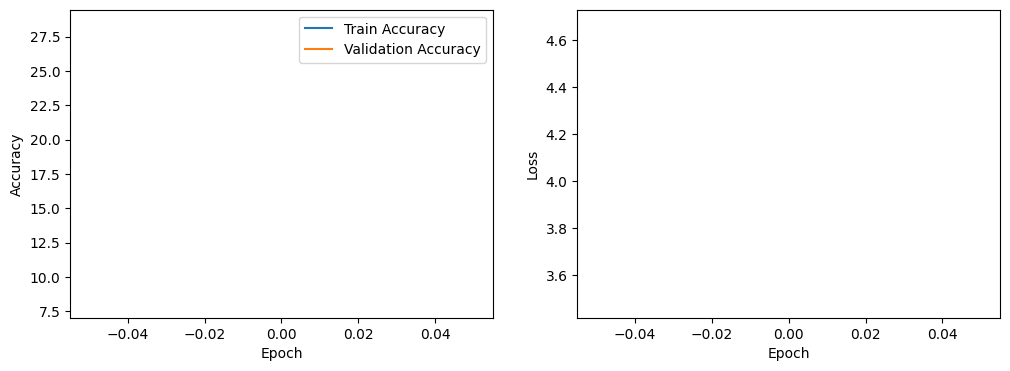

Val: Epoch [2/8], n\Loss: 2.3235, n\Accuracy: 61.9608


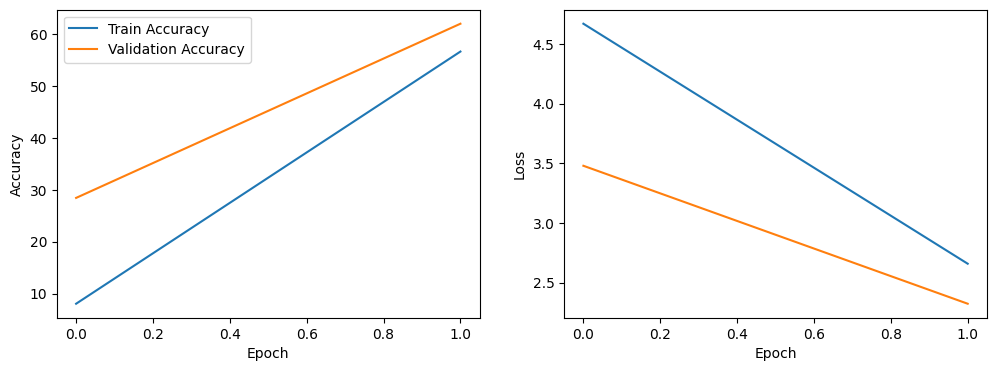

Val: Epoch [3/8], n\Loss: 1.7177, n\Accuracy: 71.0784


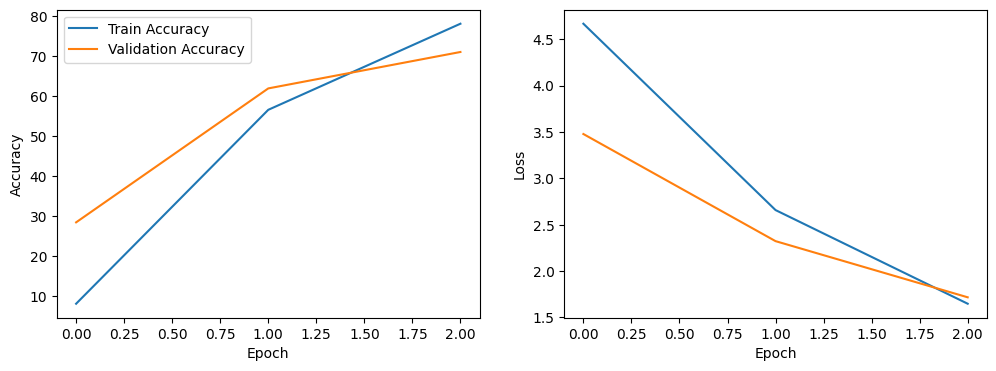

Val: Epoch [4/8], n\Loss: 1.3782, n\Accuracy: 79.1176


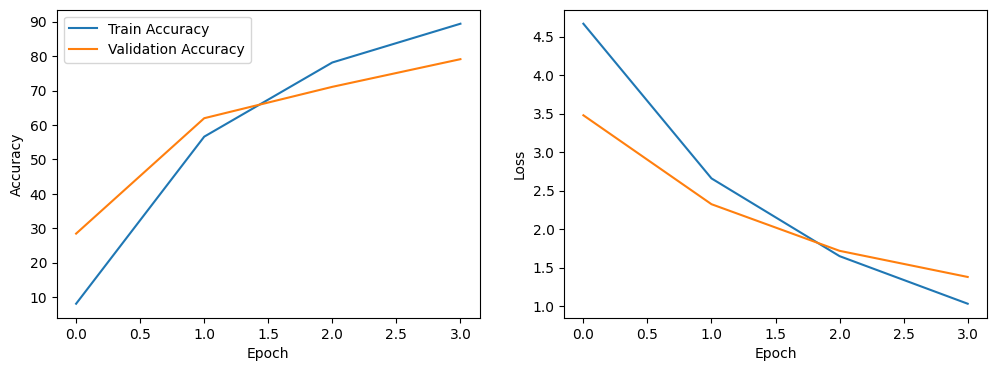

Val: Epoch [5/8], n\Loss: 1.2074, n\Accuracy: 79.8039


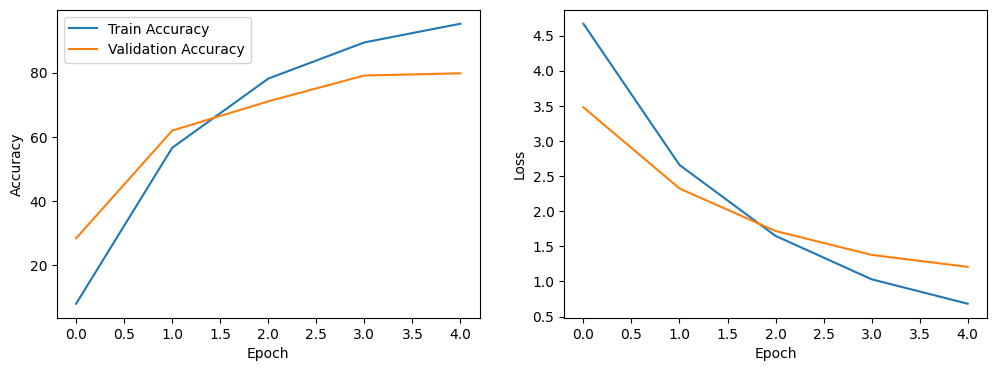

Val: Epoch [6/8], n\Loss: 1.0700, n\Accuracy: 80.0000


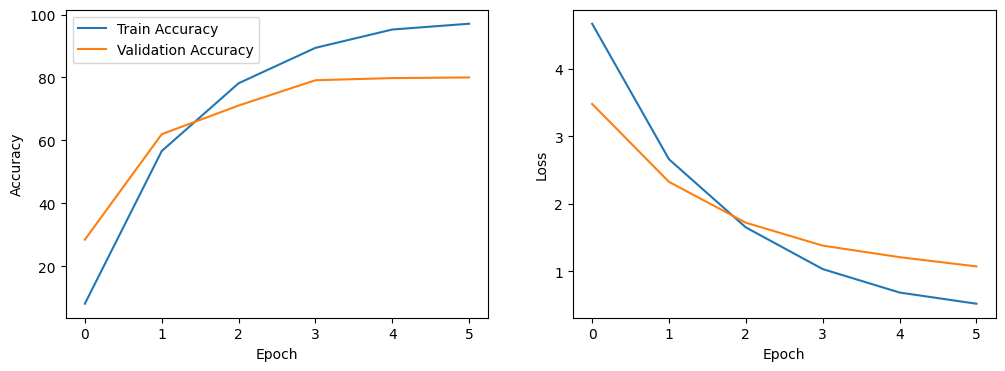

Val: Epoch [7/8], n\Loss: 0.9964, n\Accuracy: 81.8627


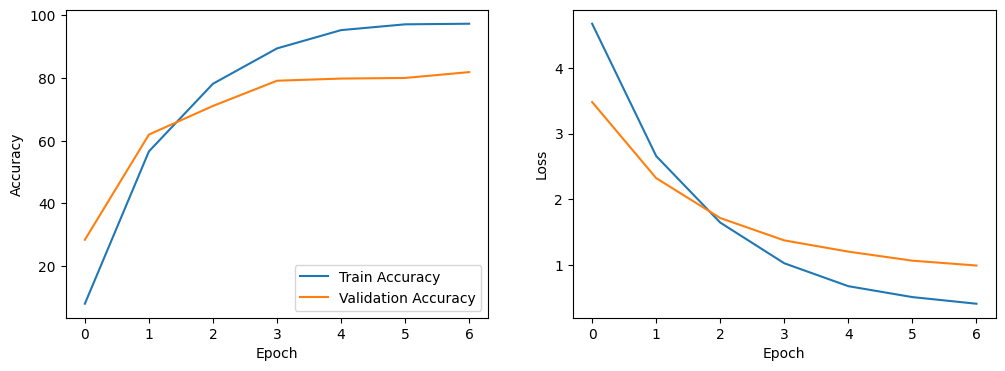

Val: Epoch [8/8], n\Loss: 0.8740, n\Accuracy: 83.9216


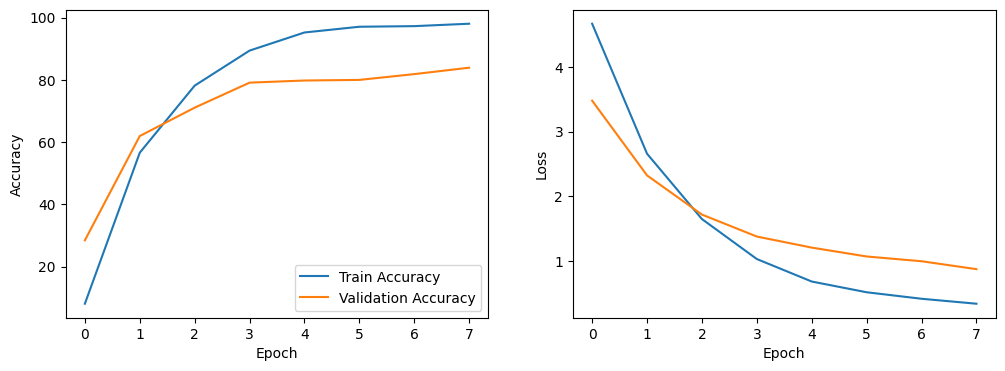

In [ ]:
train(train_loader,
      val_loader,
      model = model,
      num_epochs = num_epochs,
      device = device,
      criterion = criterion,
      optimizer = optimizer,
      lr = lr,
      path_to_save_model = path_to_save_model,
      num_classes = num_classes)

### Performance for augmented class

#### Load model

In [ ]:
#saved model
from torchvision import models
file_id = '1fL2_Qaq0U_uYqcvLwZAGjOTpcjSN6LeZ'
output = 'newmodel.pth'
gdown.download(id=file_id, output=output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1fL2_Qaq0U_uYqcvLwZAGjOTpcjSN6LeZ
From (redirected): https://drive.google.com/uc?id=1fL2_Qaq0U_uYqcvLwZAGjOTpcjSN6LeZ&confirm=t&uuid=d1611ef0-7f1e-4c31-b266-0e869520425b
To: /content/newmodel.pth
100%|██████████| 95.2M/95.2M [00:00<00:00, 100MB/s] 


'newmodel.pth'

In [ ]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 102) # 102 is the number of classes in flower102
model.load_state_dict(torch.load(output))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-45-ee3120f96e31>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Metrics calculation

In [ ]:
swapped_dict = {value: key for key, value in train_dataset.class_to_idx.items()}

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


In [ ]:
cm = confusion_matrix(all_labels, all_preds)
class_f1 = []
class_precision = []
class_recall = []
num_classes = cm.shape[0]
num_confused_classes = []

for i in range(num_classes):
  precision = cm[i, i] / np.sum(cm[:, i]) if np.sum(cm[:,i]) > 0 else 0
  recall = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i,:]) > 0 else 0
  f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
  print(f"Class: {swapped_dict[i]}, F1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")
  class_f1.append(f1)
  class_precision.append(precision)
  class_recall.append(recall)
  confused_classes = np.where(cm[i, :] > 0)[0]  # All classes where there are non-zero predictions
  confused_classes = confused_classes[confused_classes != i]  # Exclude the correct class
  num_confused_classes.append(len(confused_classes))
  print(f"Confused with classes: {confused_classes}")

Class: alpine sea holly, F1: 0.9474, precision: 1.0000, recall: 0.9000
Confused with classes: [43]
Class: anthurium, F1: 0.8889, precision: 1.0000, recall: 0.8000
Confused with classes: [19 20]
Class: artichoke, F1: 0.9474, precision: 1.0000, recall: 0.9000
Confused with classes: [51]
Class: azalea, F1: 0.7273, precision: 0.6667, recall: 0.8000
Confused with classes: [20]
Class: ball moss, F1: 0.8571, precision: 0.8182, recall: 0.9000
Confused with classes: [51]
Class: balloon flower, F1: 0.7619, precision: 0.7273, recall: 0.8000
Confused with classes: [84 90]
Class: barbeton daisy, F1: 0.9000, precision: 0.9000, recall: 0.9000
Confused with classes: [33]
Class: bearded iris, F1: 0.6316, precision: 0.6667, recall: 0.6000
Confused with classes: [31 60 74 89]
Class: bee balm, F1: 0.8000, precision: 0.8000, recall: 0.8000
Confused with classes: [54 70]
Class: bird of paradise, F1: 0.9524, precision: 0.9091, recall: 1.0000
Confused with classes: []
Class: bishop of llandaff, F1: 0.9474, pr

In [ ]:
worst_classes_indices = np.argsort(class_f1)[:20]

print("20 Classes with worst validation F1:")
for i in worst_classes_indices:
    print(f"Class: {swapped_dict[i]}, {i} F1: {class_f1[i]:.4f}, precision: {class_precision[i]:.4f}, recall: {class_recall[i]:.4f}")

20 Classes with worst validation F1:
Class: canna lily, 20 F1: 0.3000, precision: 0.3000, recall: 0.3000
Class: camellia, 19 F1: 0.3750, precision: 0.5000, recall: 0.3000
Class: canterbury bells, 21 F1: 0.5333, precision: 0.8000, recall: 0.4000
Class: rose, 78 F1: 0.5517, precision: 0.4211, recall: 0.8000
Class: desert-rose, 32 F1: 0.5556, precision: 0.6250, recall: 0.5000
Class: snapdragon, 82 F1: 0.5714, precision: 0.5455, recall: 0.6000
Class: clematis, 25 F1: 0.5714, precision: 1.0000, recall: 0.4000
Class: sweet william, 88 F1: 0.5882, precision: 0.7143, recall: 0.5000
Class: sword lily, 89 F1: 0.6000, precision: 0.6000, recall: 0.6000
Class: sweet pea, 87 F1: 0.6316, precision: 0.6667, recall: 0.6000
Class: bearded iris, 7 F1: 0.6316, precision: 0.6667, recall: 0.6000
Class: lenten rose, 52 F1: 0.6364, precision: 0.5833, recall: 0.7000
Class: passion flower, 66 F1: 0.6667, precision: 1.0000, recall: 0.5000
Class: peruvian lily, 68 F1: 0.6667, precision: 0.5714, recall: 0.8000
Cla

In [ ]:
train_dataset.class_to_idx['sword lily']

89

In [ ]:
all_labels == 89

False

In [ ]:
np.where(all_labels == )

<ipython-input-46-91b2514db7d7>:1: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  np.where(all_labels == train_dataset.class_to_idx['sword lily'])


(array([], dtype=int64),)

In [ ]:
class_num = train_dataset.class_to_idx['sword lily']
indices = np.where(np.array(all_labels) == class_num)[0]
preds_worst_class = np.array(all_preds)[indices]
[swapped_dict[i] for i in preds_worst_class]

['sword lily',
 'monkshood',
 'sword lily',
 'hibiscus',
 'sword lily',
 'sword lily',
 'sword lily',
 'siam tulip',
 'canna lily',
 'sword lily']